<a href="https://colab.research.google.com/github/Jollyhrothgar/wordle/blob/main/Wordle_Solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Wordle is a word guessing game where the player needs to guess a five letter word. There are six chances to get the word right, and with each guess, you get information:

* Letters that are not in the word
* Letters that are in the word, but are not in the right position
* Letters thar are in the word and in the right position

## Games

* [Wordle](https://www.powerlanguage.co.uk/wordle/)
* [Lewdle](https://www.lewdlegame.com/)

# Strategy

Since the first word is a complete guess, the optimal guess is the one that obtains the most information. Some strageies:

## Letter frequencies

Goal: try to eliminate as many letters as possible.

1. Pick a word with distinct letters
2. Choose a word that contains the most common letters
3. First guess eliminates the most uncertainty

## Letter position frequencies

Goal: try to eliminate as many positions as possible

1. Pick a word that has distinct letters, as well as most common letter positions
2. Choose word that eliminates the most position-letter pairs
3. First guess (hopefully) eliminates both a letter AND a position.

In [1]:
#@title Imports
import urllib.request as request
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import re

In [256]:
#@title Utils

def load_wordlist_from_url(url):
  """Assume URL hosts a plan newline deliminated wordlist, and load to array"""
  return [line.decode("utf-8").strip().lower() for line in request.urlopen(url)]

def make_word_df(word_list):
  """Create the word dataframe data structure"""
  words = pd.DataFrame(word_list, columns=['word'])
  words[1] = words['word'].apply(lambda x: x[0])
  words[2] = words['word'].apply(lambda x: x[1])
  words[3] = words['word'].apply(lambda x: x[2])
  words[4] = words['word'].apply(lambda x: x[3])
  words[5] = words['word'].apply(lambda x: x[4])

  return words

class Guesser(object):
  def __init__(self, word_df):
    self.word_df = word_df
    self.orignal_word_df = word_df.copy(deep=True)
    self.compute_probability_and_frequency()
    self.solved = {
        1: "?",
        2: "?",
        3: "?",
        4: "?",
        5: "?",
    }
  
  def is_solved(self):
    return len(self.word_df) == 1
  
  def snapshot_word_list(self):
    self.snapshot = self.word_df.copy(deep=True)

  def restore_word_list_snapshot(self):
    self.word_df = self.snapshot.copy(deep=True)

  def compute_probability_and_frequency(self):
    """Given a word_list of words, compute the joint probability of all letter
    positions."""
    letter_frequency = pd.Series(
        [letter for word in self.word_df['word'].values for letter in word]
    ).value_counts(normalize=True).sort_index()
  
    position_frequency = pd.concat(
      [
        self.word_df[1].value_counts(),
        self.word_df[2].value_counts(),
        self.word_df[3].value_counts(),
        self.word_df[4].value_counts(),
        self.word_df[5].value_counts()
      ],
      axis=1
    ).fillna(0)
    position_joint = position_frequency.div(position_frequency.sum()).sort_index()
  
    self.position_joint = position_joint  
    self.letter_frequency = letter_frequency

  def pick_word(self, strategy='letter_frequency'):
    """Pick word based on strategy"""
    self.snapshot_word_list()

    if strategy=='letter_frequency':
      if self.word_df.shape[0] == 1:
        return self.word_list['word'].values[0]
  
      letters = self.letter_frequency.sort_values(ascending=False).index.values
      solved_letters = set(self.solved.values())
  
      try:
        solved_letters.remove('?')
      except:
        pass
  
      letters = list(set(letters).difference(solved_letters))
      
      counter = 0
      letter = letters.pop(0)
      list_length = sum(self.word_df['word'].str.contains(letter) > 0)
  
      while list_length > 0:
        self.word_df = self.word_df[self.word_df['word'].str.contains(letter) > 0]
        list_length = sum(self.word_df['word'].str.contains(letter) > 0)
        try:
          letter = letters.pop(0)
        except IndexError: # no more letters to pop, we're in anagram land.
          break
        counter += 1
        if counter == 5:
          break
      self.restore_word_list_snapshot()
      return self.word_df.sample(1)['word'].values[0]
    else:
      # Default is random
      return self.word_df.sample(1)['word'].values[0]
  
  def guess(self, guess, secret_word, silent=False):
    """Call self.add_hint using a guessed word and a secret word.
    """
    word_count = self.word_df.shape[0]

    # Check for location matches
    for (i, letter) in enumerate(guess):
      if guess[i] == secret_word[i]:
        self.add_hint(letter=letter, location=i+1)
        if not silent:
          print(f'\t{letter} is solved at {i+1}')
      elif letter in secret_word:
        if not silent:
          print(f'\t{letter} is in secret word')
        self.add_hint(letter=letter, location=-1*(i+1))
      else:
        if not silent:
          print(f'\t{letter} is not in the word.')
        self.add_hint(letter=letter)

    return word_count - self.word_df.shape[0]
      
  def add_hint(self, letter, location=None, silent=True):
    """Add a hint about information in the word

    letter: a lowercase letter in the alphabet
    location: takes on following values / meaning:
      None: the letter is not in the word
      (-1, -2, -3, -4, -5): the letter is in the word, but NOT in the position
      (1, 2, 3, 4, 5): the letter is in the position.
    state: True or False - true if the position has the letter, false if it
      doesn't.
    """

    # Apply logic in a way that doens't require knowledge of previous moves
    # and does not reduce the word-list to zero words.
    if location is None:
      temp_df = self.word_df[~self.word_df['word'].str.contains(letter)]
      if len(temp_df) != 0:
        self.word_df = temp_df
    else:
      if location > 0:
        temp_df = self.word_df[self.word_df[location] == letter]
        if len(temp_df) != 0:
          self.word_df = temp_df
      else:
        location = abs(location)
        temp_df = self.word_df[self.word_df[location] != letter]
        if len(temp_df) != 0:
          self.word_df = temp_df
        
        temp_df = self.word_df[self.word_df['word'].str.contains(letter)]
        if len(temp_df) != 0:
          self.word_df = temp_df

    self.compute_probability_and_frequency()
    for pos in [1, 2, 3, 4, 5]:
      # Floating point, be careful.
      if max(self.position_joint[pos]) > 0.99999:
        self.solved[pos] = self.position_joint[pos].idxmax()
    
    if self.is_solved():
      if not silent:
        print(f"\tSecret word is solved: {self.word_df['word'].values[0]}")

  def plot_words(self):
    words_df = self.compute_probability_and_frequency()

    fig, (ax_l, ax_r) = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))

    # Letter Joint
    sns.heatmap(self.position_joint, cmap='Blues', annot=True, fmt='.3f', ax=ax_l)
    ax_l.set_title('Wordle Joint Distribution \n $P(letter, position)$')
  
    # Letter frequency
    self.letter_frequency.plot.bar(
        title='letter frequency',
        xlabel='letter',
        ylabel='frequency',
        ax=ax_r
    )

In [257]:
#@title choose a word list
url = "https://raw.githubusercontent.com/Jollyhrothgar/wordle/main/wordle.txt" #@param ["https://raw.githubusercontent.com/Jollyhrothgar/wordle/main/lewdle.txt", "https://raw.githubusercontent.com/Jollyhrothgar/wordle/main/wordle.txt"]
wordlist = load_wordlist_from_url(url)
word_df = make_word_df(wordlist)
print(f"Wordlist conistst of a vocabulary of {len(wordlist)} words.")

Wordlist conistst of a vocabulary of 12972 words.


# Simulate the game

I've retooled the class to simulate wordle. A secret word is chosen from the library, and we add support for automatically filtering the wordlist with hints using a secret word and a guess.

- Running this simulation, I've noticed that the filtration is not perfect. For example, if we know that a letter is in another position, but only one word in the dataset has this word, then we can eliminate more words.


In [258]:
def simulate_policy(policy):
  counter = 1
  
  secret_word = word_df.sample(1)['word'].values[0]
  sim = Guesser(word_df)
  while not sim.is_solved():
    word = sim.pick_word(strategy=policy)
    eliminated = sim.guess(word, secret_word, silent=True)
    # print(f"{counter} turn, {word} guessed, {secret_word} target, {eliminated} eliminated")
    counter += 1
  
  # print(f"SOLVED {counter} turn, {word} guessed, {secret_word} target, {eliminated} eliminated")

  return counter

In [260]:
random = [simulate_policy(policy='random') for i in range(100)]
letter_frequency = [simulate_policy(policy='letter_frequency') for i in range(100)]

My alg is worse than random, =(.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


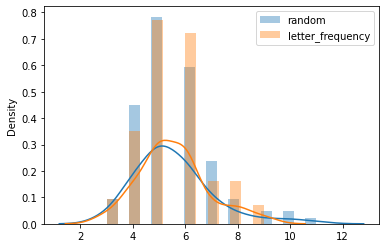

In [261]:
sns.distplot(random, label='random')
sns.distplot(letter_frequency, label='letter_frequency')
plt.legend()

# Strategy - Example 1

Here, we manually execute a hybrid strategy, using the live wordle UI to validate responses.

The general strategy I used was:

1. Choose the most likely letter-position, so long as it was in the top 5 of the current known set.

2. Refilter the list with the guess in step `1.`, repeat step 1.

3. Continue until we have all guessed letters and positions.

This strategy reduced the word-list length in the first step by a factor of 10, but seemed to suffer as the list became shorter and shorter.

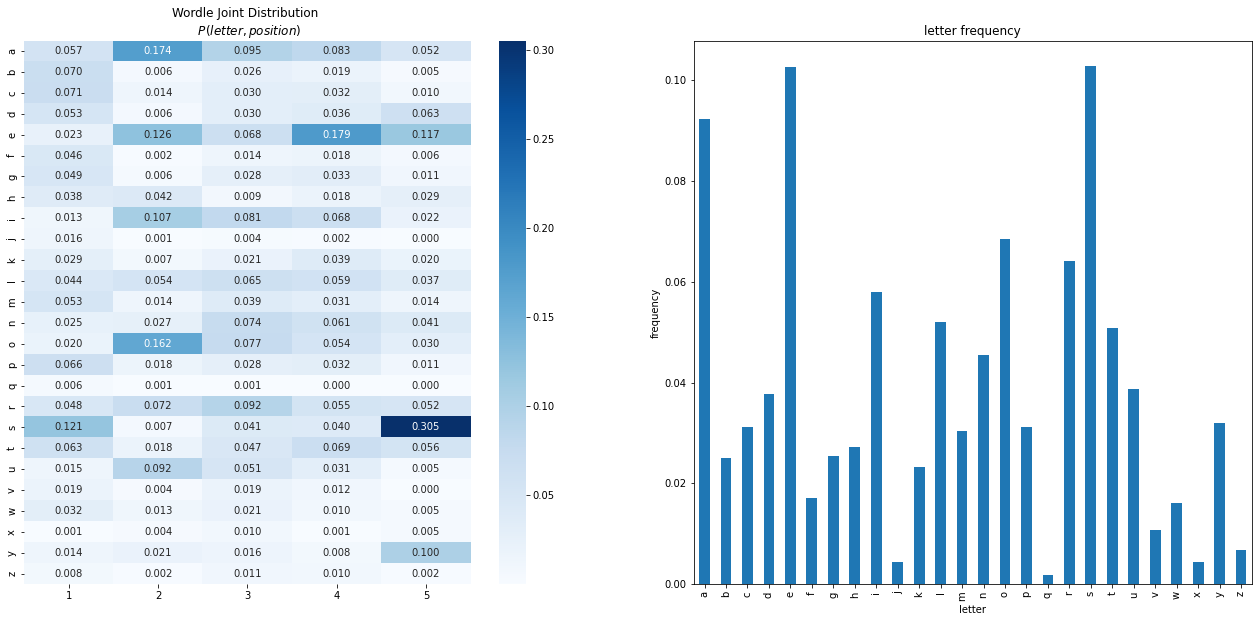

In [242]:
words = make_word_df(wordlist)
game = Guesser(word_df=words)
game.plot_words()

In [243]:
game.add_hint(letter='r')
game.add_hint(letter='e')
game.add_hint(letter='a')
game.add_hint(letter='s')
game.add_hint(letter='l', location=4)

In [244]:
game.word_df

,word,1,2,3,4,5
99,moult,m,o,u,l,t
109,guild,g,u,i,l,d
150,chill,c,h,i,l,l
219,knoll,k,n,o,l,l
224,could,c,o,u,l,d
...,...,...,...,...,...,...
12330,voulu,v,o,u,l,u
12522,whilk,w,h,i,l,k
12619,wolly,w,o,l,l,y
12633,woold,w,o,o,l,d


In [245]:
game.solved

{1: '?', 2: '?', 3: '?', 4: 'l', 5: '?'}

In [246]:
game.snapshot_word_list()

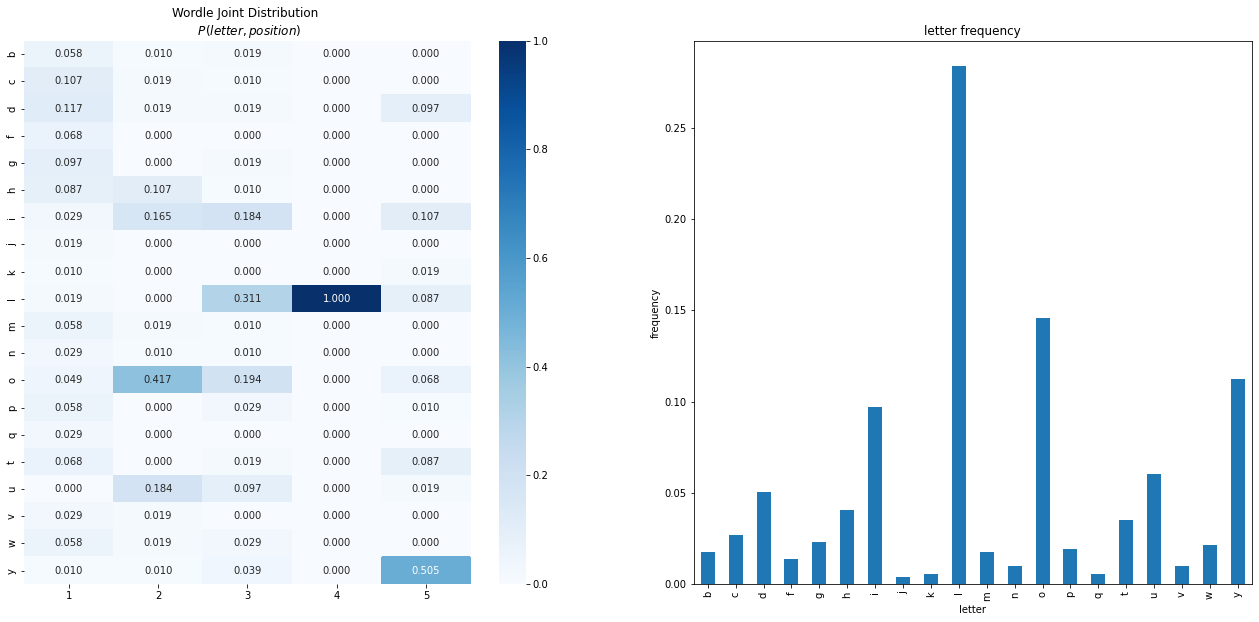

In [247]:
game.plot_words()

In [248]:
game.add_hint(letter='o', location=-2)
game.add_hint(letter='d')
game.add_hint(letter='i')
game.add_hint(letter='y')

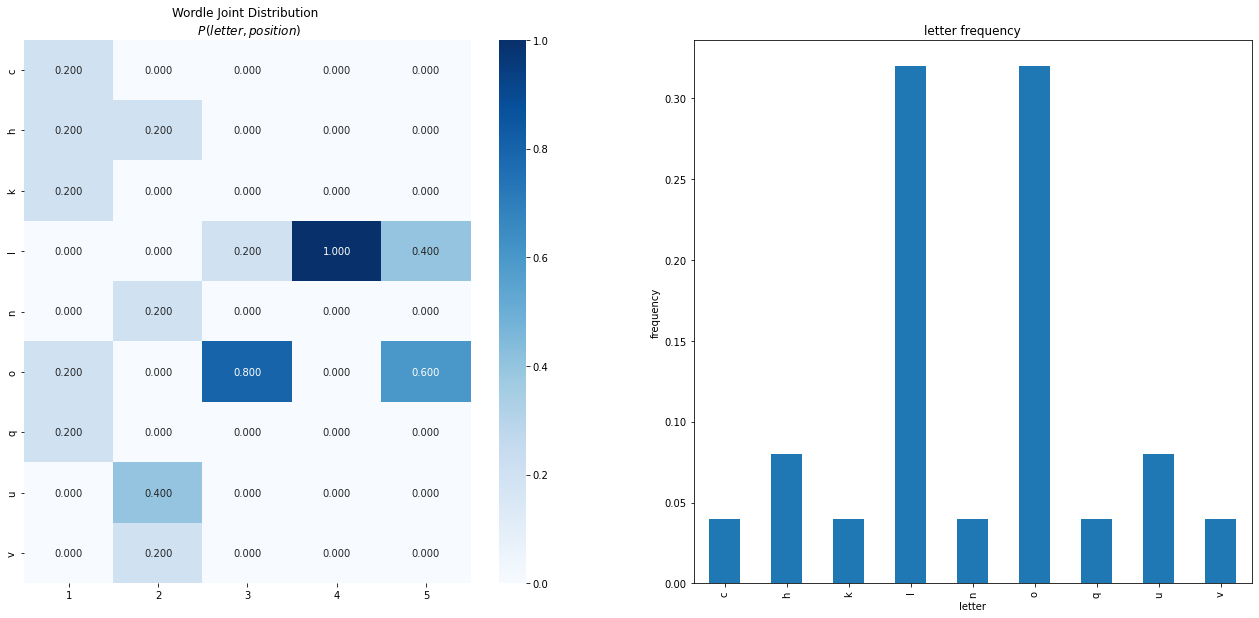

In [249]:
game.plot_words()

In [250]:
game.word_df

,word,1,2,3,4,5
219,knoll,k,n,o,l,l
3904,cholo,c,h,o,l,o
6538,hullo,h,u,l,l,o
8811,ovolo,o,v,o,l,o
9601,quoll,q,u,o,l,l


In [251]:
game.snapshot_word_list()

In [252]:
game.restore_word_list_snapshot()

In [253]:
game.add_hint(letter='l', location=5)
game.add_hint(letter='q', location=-1)

	Secret word is solved: knoll


In [254]:
game.word_df

,word,1,2,3,4,5
219,knoll,k,n,o,l,l


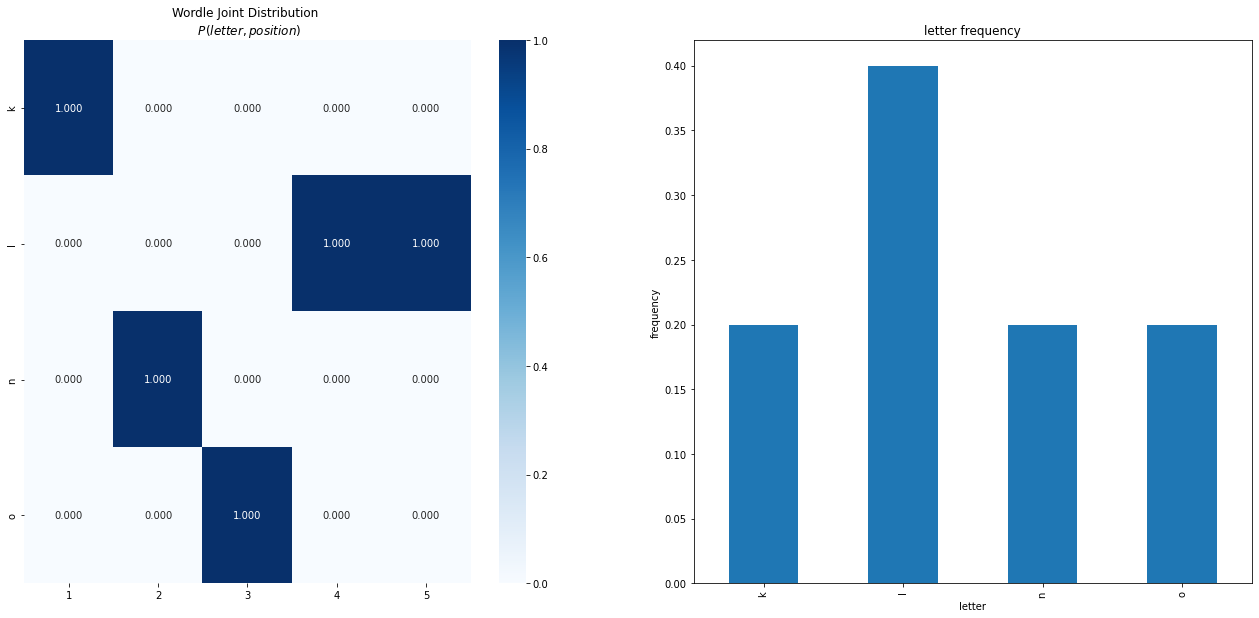

In [255]:
game.plot_words()